In [1]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from keras.utils.vis_utils import plot_model
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer


import warnings
warnings.filterwarnings("ignore")

2024-04-11 14:16:51.685249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Importing Data

### Tweets

Tweets for corresponding stock tickers from 30-09-2021 till 30-09-2022

In [262]:
stock_name = 'TSLA'

all_tweets = pd.read_csv('stock_tweets.csv')

In [3]:
df = all_tweets[all_tweets['Stock Name'] == stock_name]
print(df.shape)
df.head()

(37422, 4)


Date  \
0  2022-09-29 23:41:16+00:00   
1  2022-09-29 23:24:43+00:00   
2  2022-09-29 23:18:08+00:00   
3  2022-09-29 22:40:07+00:00   
4  2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.  
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.  
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.  
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.  
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.

In [4]:
sent_df = df.copy()
sent_df["sentiment_score"] = ''
sent_df["Negative"] = ''
sent_df["Neutral"] = ''
sent_df["Positive"] = ''
sent_df.head()

Date  \
0  2022-09-29 23:41:16+00:00   
1  2022-09-29 23:24:43+00:00   
2  2022-09-29 23:18:08+00:00   
3  2022-09-29 22:40:07+00:00   
4  2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  \
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.   
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.   
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.   
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.   
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.   

  sentiment_score Negative Neutral Positive  
0                                            
1                                            
2                                            
3                                            
4

In [5]:
%%time
sentiment_analyzer = SentimentIntensityAnalyzer()
for indx, row in sent_df.T.iteritems():
    try:
        sentence_i = unicodedata.normalize('NFKD', sent_df.loc[indx, 'Tweet'])
        sentence_sentiment = sentiment_analyzer.polarity_scores(sentence_i)
        sent_df.at[indx, 'sentiment_score'] = sentence_sentiment['compound']
        sent_df.at[indx, 'Negative'] = sentence_sentiment['neg']
        sent_df.at[indx, 'Neutral'] = sentence_sentiment['neu']
        sent_df.at[indx, 'Positive'] = sentence_sentiment['pos']
    except TypeError:
        print (sent_df.loc[indexx, 'Tweet'])
        print (indx)
        break

CPU times: user 10.3 s, sys: 38.5 ms, total: 10.3 s
Wall time: 10.4 s


In [6]:
sent_df.head()

Date  \
0  2022-09-29 23:41:16+00:00   
1  2022-09-29 23:24:43+00:00   
2  2022-09-29 23:18:08+00:00   
3  2022-09-29 22:40:07+00:00   
4  2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  \
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.   
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.   
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.   
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.   
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.   

  sentiment_score Negative Neutral Positive  
0          0.0772    0.127   0.758    0.115  
1             0.0      0.0     1.0      0.0  
2           0.296      0.0   0.951    0.049  
3         -0.7568    0.273    0.59    0.137  
4          -0.875    0.526   0.474      0.0

In [7]:
sent_df.at[4,'Tweet']

'@RealDanODowd @Tesla Stop trying to kill kids, you sad deranged old man'

In [8]:
sent_df['Date'] = pd.to_datetime(sent_df['Date'])
sent_df['Date'] = sent_df['Date'].dt.date
sent_df = sent_df.drop(columns=['Negative', 'Positive', 'Neutral', 'Stock Name', 'Company Name'])

In [9]:
sent_df.head()

Date                                              Tweet  \
0  2022-09-29  Mainstream media has done an amazing job at br...   
1  2022-09-29  Tesla delivery estimates are at around 364k fr...   
2  2022-09-29  3/ Even if I include 63.0M unvested RSUs as of...   
3  2022-09-29  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...   
4  2022-09-29  @RealDanODowd @Tesla Stop trying to kill kids,...   

  sentiment_score  
0          0.0772  
1             0.0  
2           0.296  
3         -0.7568  
4          -0.875

As the result of sentiment analysis we get average polarity scores of all tweets about a cartain stock ticker for each day:

In [11]:
twitter_df = sent_df.groupby([sent_df['Date']]).mean()
print(twitter_df.shape)

(365, 1)


In [283]:
twitter_df.head()

sentiment_score
Date                       
2021-09-30         0.231552
2021-10-01         0.233704
2021-10-02         0.271940
2021-10-03         0.271570
2021-10-04         0.135388

### Financial data

In [13]:
all_stocks = pd.read_csv('stock_yfinance_data.csv')
print(all_stocks.shape)
all_stocks.head()

(6300, 8)


Date        Open        High         Low       Close   Adj Close  \
0  2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1  2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2  2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
3  2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
4  2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   

     Volume Stock Name  
0  53868000       TSLA  
1  51094200       TSLA  
2  91449900       TSLA  
3  55297800       TSLA  
4  43898400       TSLA

Filter Tesla & convert data format

In [14]:
stock_df = all_stocks[all_stocks['Stock Name'] == stock_name]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date

In [15]:
stock_df

Date        Open        High         Low       Close   Adj Close  \
0    2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1    2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2    2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
3    2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
4    2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   
..          ...         ...         ...         ...         ...         ...   
247  2022-09-23  283.089996  284.500000  272.820007  275.329987  275.329987   
248  2022-09-26  271.829987  284.089996  270.309998  276.010010  276.010010   
249  2022-09-27  283.839996  288.670013  277.510010  282.940002  282.940002   
250  2022-09-28  283.079987  289.000000  277.570007  287.809998  287.809998   
251  2022-09-29  282.760010  283.649994  265.779999  268.209991  268.209991   

       Volume Stock Name  
0    53868000       TSLA  
1    51094200       TSLA  
2    91449900       TSLA  
3    55297800       TSLA  
4    43898400       TSLA  
..        ...        ...  
247  63748400       TSLA  
248  58076900       TSLA  
249  61925200       TSLA  
250  54664800       TSLA  
251  77620600       TSLA  

[252 rows x 8 columns]

### Join two datasets

In [16]:
# Stock market doesn't open on weekend...?
final_df = stock_df.join(twitter_df, how="left", on="Date")
final_df = final_df.drop(columns=['Stock Name'])
print(final_df.shape)

(252, 8)


In [17]:
final_df.head()

Date        Open        High         Low       Close   Adj Close  \
0  2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1  2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2  2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
3  2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
4  2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   

     Volume  sentiment_score  
0  53868000         0.231552  
1  51094200         0.233704  
2  91449900         0.135388  
3  55297800         0.069445  
4  43898400         0.199940

### Exploratory Data Analysis

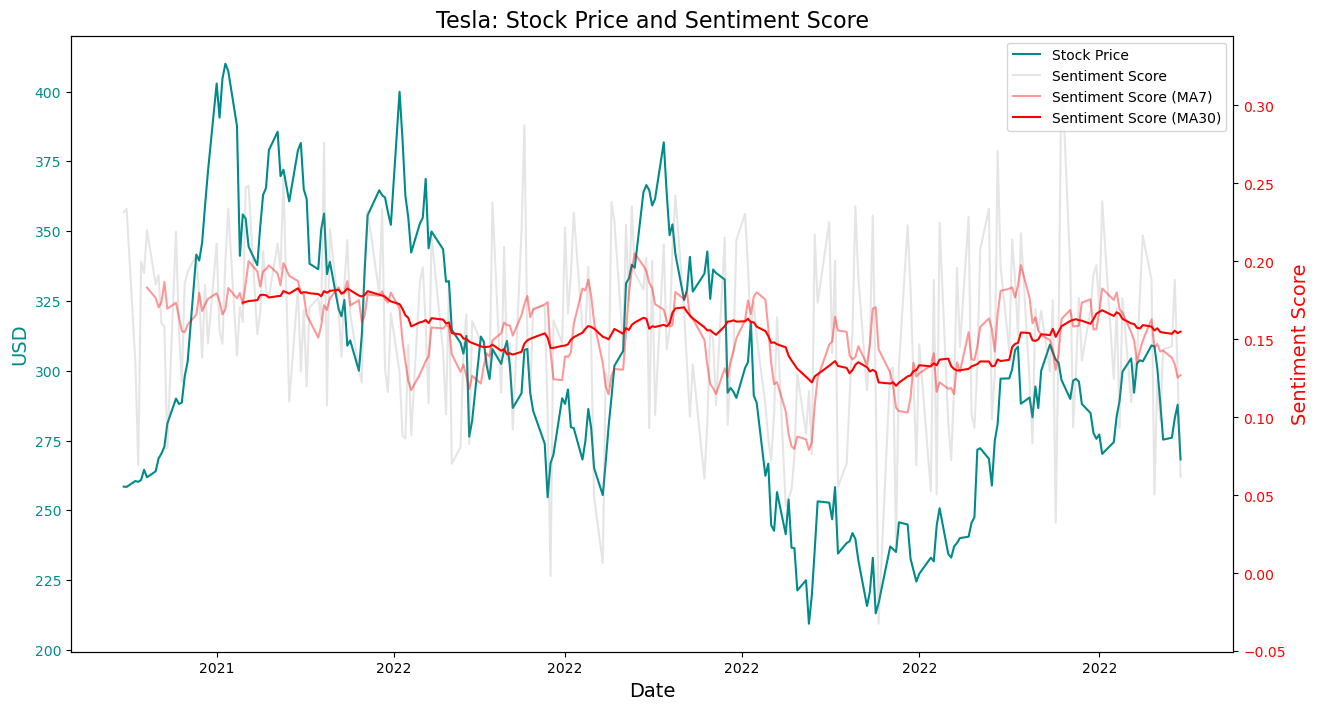

In [273]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

fig, ax1 = plt.subplots(figsize=(15,8))

# Plot the stock price on ax1
ax1.plot(final_df['Date'], final_df['Close'], color='#008B8B', label='Stock Price')
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('USD', fontsize=14, color='#008B8B')
ax1.tick_params(axis='y', labelcolor='#008B8B')
ax1.xaxis.set_major_formatter(DateFormatter("%Y"))

# Create a second y-axis for the sentiment score
ax2 = ax1.twinx()
ax2.plot(final_df['Date'], final_df['sentiment_score'], color='grey', label='Sentiment Score', alpha=0.2)
ax2.plot(final_df['Date'], final_df['sentiment_score'].rolling(window=7).mean(), color='red', label='Sentiment Score (MA7)', alpha=0.4)
ax2.plot(final_df['Date'], final_df['sentiment_score'].rolling(window=30).mean(), color='red', label='Sentiment Score (MA30)', alpha=1)

ax2.set_ylabel('Sentiment Score', fontsize=14, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set the title for the plot
ax1.set_title(f"Tesla: Stock Price and Sentiment Score", fontsize=16)

# Optional: Add a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right') #loc='upper right'

plt.show()

# Adding technical indicators

To help the network understand the bigger picture of the market we add different technical indicators to the training data, such as moving averages, Bollinger bands etc., which describe the development of stock price not only for the current day, but for the past week or more.

MA(7) stans for Moving Average for past 7 days, whereas MA(20) means Moving Average for past 20 days.

EMA is Exponential Moving average and we can calculate it as:

EMA_t = Pclose + (EMA_t-1 (100 - P))*
Bollinger Bands are calculated as:

middle line: stdev(MA(20))
upper bound: MA(20) + 2stdev(MA(20))
lower bound: MA(20) - 2stdev(MA(20))

In [20]:
def get_tech_ind(data):
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean() #Close column
    data['MA20'] = data.iloc[:,4].rolling(window=20).mean() #Close Column

    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()
    #This is the difference of Closing price and Opening Price

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data

In [21]:
tech_df = get_tech_ind(final_df)
# The first 20 days didn't has rolling average...
dataset = tech_df.iloc[20:,:].reset_index(drop=True)
dataset.head()

Date        Open        High         Low       Close   Adj Close  \
0  2021-10-28  356.103333  360.333344  351.399994  359.013336  359.013336   
1  2021-10-29  360.619995  371.736664  357.736664  371.333344  371.333344   
2  2021-11-01  381.666656  403.250000  372.886658  402.863342  402.863342   
3  2021-11-02  386.453339  402.863342  382.000000  390.666656  390.666656   
4  2021-11-03  392.443329  405.130005  384.206665  404.619995  404.619995   

      Volume  sentiment_score         MA7        MA20       MACD       20SD  \
0   81639600         0.185287  325.127141  288.855501  -9.269895  32.580099   
1   89755200         0.147279  336.946189  294.501834 -10.609662  36.566908   
2  168146100         0.211411  351.926666  301.619501 -11.860446  42.906989   
3  128213400         0.155453  364.418095  308.143001 -14.295169  46.078655   
4  103885500         0.147228  373.418095  315.328168 -15.716662  49.410503   

   upper_band  lower_band         EMA  logmomentum  
0  354.015698  223.695304  353.510805     5.880570  
1  367.635649  221.368019  365.392497     5.914404  
2  387.433479  215.805523  390.373061     5.996112  
3  400.300312  215.985690  390.568791     5.965292  
4  414.149173  216.507162  399.936260     6.000474

In [22]:
def tech_ind(dataset):
    fig,ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset['Date'], dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
    ax.plot(dataset['Date'], dataset['Close'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset['Date'], dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.title('Technical indicators')
    plt.ylabel('Close (USD)')
    plt.xlabel("Year")
    plt.legend()

    plt.show()

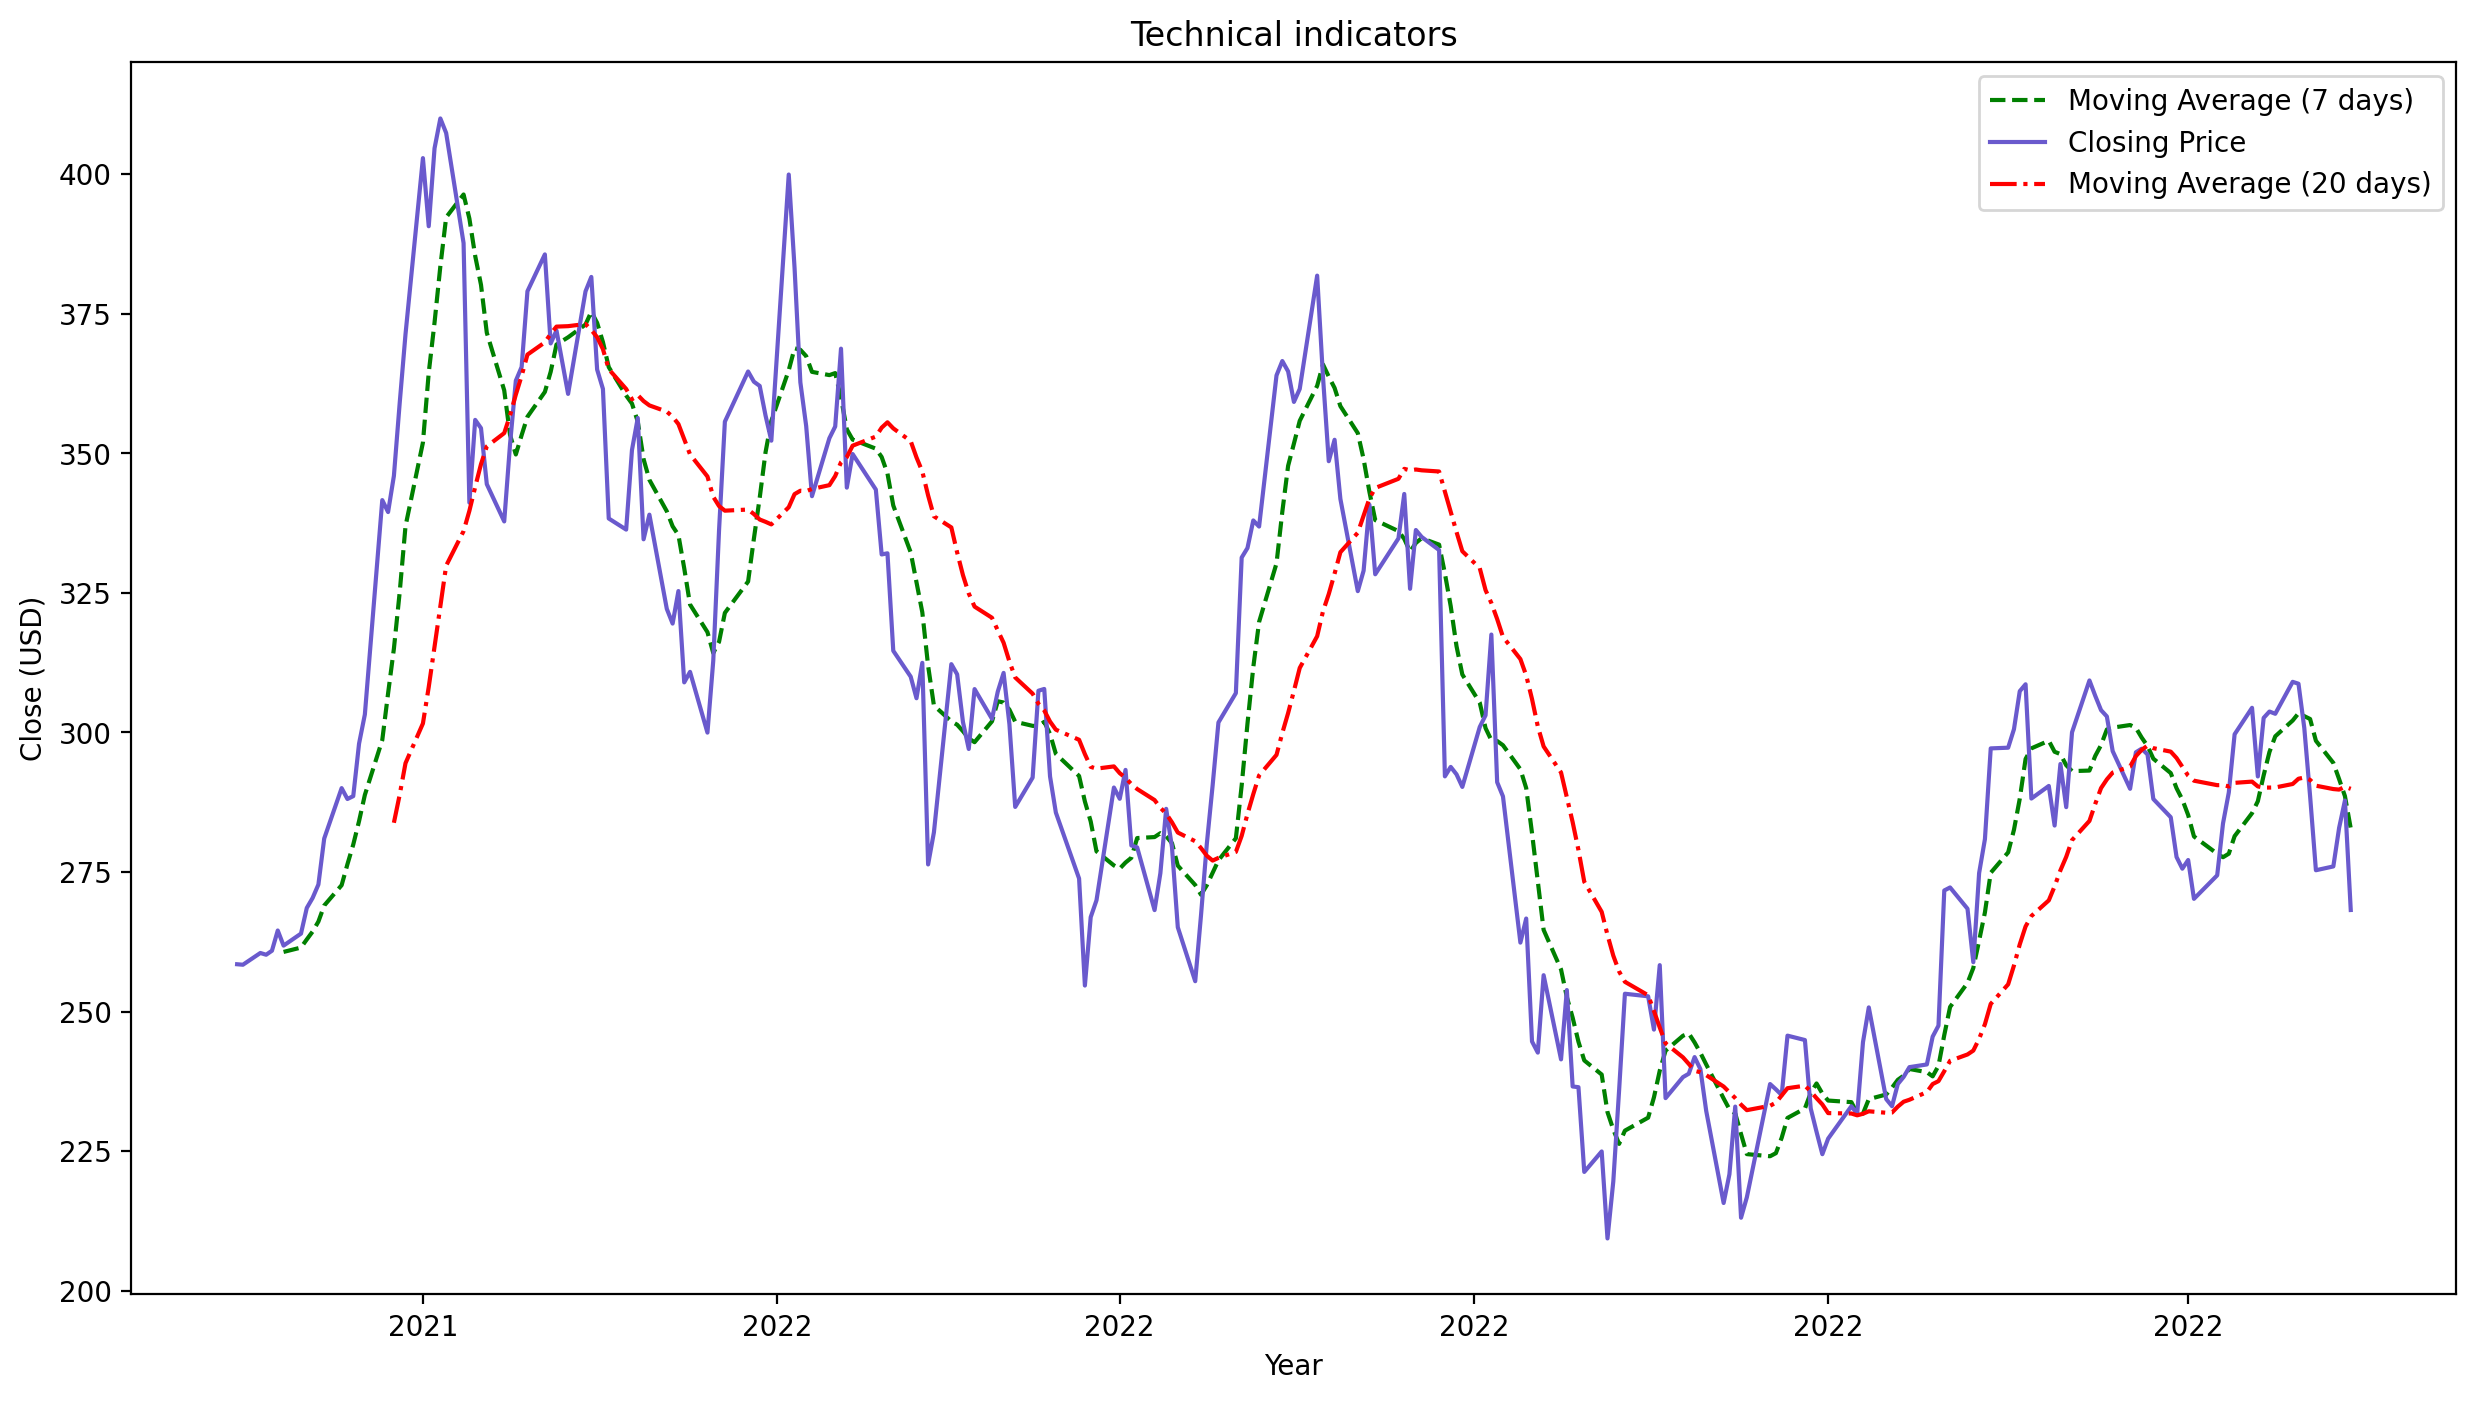

In [23]:
tech_ind(tech_df)

# Pre-processing for RNN

### Convert index to dates

In [24]:
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])

In [25]:
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')

In [140]:
dataset2 = dataset[['Close', 'sentiment_score']]

In [171]:
# Close = Stock prices at the market's close time
# sentiment_score = compound score in VADER's SentimentIntensityAnalyzer
dataset2

Close  sentiment_score
2021-10-28  359.013336         0.185287
2021-10-29  371.333344         0.147279
2021-11-01  402.863342         0.211411
2021-11-02  390.666656         0.155453
2021-11-03  404.619995         0.147228
...                ...              ...
2022-09-23  275.329987         0.143601
2022-09-26  276.010010         0.145532
2022-09-27  282.940002         0.188188
2022-09-28  287.809998         0.127383
2022-09-29  268.209991         0.062029

[232 rows x 2 columns]

In [141]:
def normalize_data(df, range, target_column):

    '''
    df: dataframe object
    range: type tuple -> (lower_bound, upper_bound)
        lower_bound: int
        upper_bound: int
    target_column: type str -> should reflect closing price of stock
    '''

    target_df_series = pd.DataFrame(df[target_column]) # 'Close'
    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)
    
    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return X_scaler, y_scaler, X_scale_dataset,y_scale_dataset

In [142]:
def batch_data(x_data,y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()

    for i in range(0,len(x_data),1):
        x_value = x_data[i: i + batch_size][:, :] # 1 datapoint = day1 to day5  (5,15)
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0] # stock price (Close) for day6 (1,)
        yc_value = y_data[i: i + batch_size][:, :] # stock price (Close) for day1 to day5 (5,1)
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)

    return np.array(X_batched), np.array(y_batched), np.array(yc)

In [143]:
def split_train_test(data, test_days=20):
    # test data = latest 20 days
    train_size = len(data) - test_days
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [144]:
def predict_index(dataset, X_train, batch_size, prediction_period):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

In [229]:
X_scaler, y_scaler, X_scale_dataset, y_scale_dataset = normalize_data(dataset2, (-1,1), "Close") # (232,15), (232, 1)
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size = 30, predict_period = 1) # (227, 5, 15)

print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, 5, 1)

X shape: (202, 30, 2)
y shape: (202, 1)
yc shape: (202, 30, 1)


In [282]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (182, 30, 2)
X_test shape: (20, 30, 2)
y_train shape: (182, 1)
y_test shape: (20, 1)


### Converting data into PyTorch Tensor format

In [230]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [231]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [232]:
# Assuming X_train, y_train, X_test, y_test are already loaded as numpy arrays
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create Tensor datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create Data Loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [233]:
X_test_tensor.shape

torch.Size([20, 30, 2])

# Model Building

In [234]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, device=device):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.device = device

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(1, x.size(0), self.hidden_dim).to(self.device)
        # Initialize cell state
        c0 = torch.zeros(1, x.size(0), self.hidden_dim).to(self.device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [235]:
input_dim = X_train.shape[1] 
feature_size = X_train.shape[2] 
output_dim = y_train.shape[1]
print(input_dim, feature_size, output_dim)

30 2 1


In [236]:
# Model configuration
input_dim = X_train.shape[2]  # number of features per step
hidden_dim = 50  # number of features in hidden state
output_dim = y_train.shape[1]  # output dimension

model = LSTMModel(input_dim, hidden_dim, output_dim)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00)

# Training

In [237]:
# Training function with loss recording
def train(model, train_loader, criterion, optimizer, num_epochs=100):
    model.train()
    losses = []
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')
    return losses

In [238]:
# Train the model and get losses
losses = train(model, train_loader, criterion, optimizer)

Epoch 1, Loss: 0.2484
Epoch 2, Loss: 0.2028
Epoch 3, Loss: 0.1647
Epoch 4, Loss: 0.1386
Epoch 5, Loss: 0.1231
Epoch 6, Loss: 0.0941
Epoch 7, Loss: 0.0708
Epoch 8, Loss: 0.0596
Epoch 9, Loss: 0.0562
Epoch 10, Loss: 0.0522
Epoch 11, Loss: 0.0480
Epoch 12, Loss: 0.0438
Epoch 13, Loss: 0.0418
Epoch 14, Loss: 0.0383
Epoch 15, Loss: 0.0370
Epoch 16, Loss: 0.0348
Epoch 17, Loss: 0.0339
Epoch 18, Loss: 0.0322
Epoch 19, Loss: 0.0317
Epoch 20, Loss: 0.0319
Epoch 21, Loss: 0.0317
Epoch 22, Loss: 0.0313
Epoch 23, Loss: 0.0287
Epoch 24, Loss: 0.0290
Epoch 25, Loss: 0.0281
Epoch 26, Loss: 0.0280
Epoch 27, Loss: 0.0270
Epoch 28, Loss: 0.0265
Epoch 29, Loss: 0.0271
Epoch 30, Loss: 0.0258
Epoch 31, Loss: 0.0260
Epoch 32, Loss: 0.0253
Epoch 33, Loss: 0.0245
Epoch 34, Loss: 0.0243
Epoch 35, Loss: 0.0232
Epoch 36, Loss: 0.0239
Epoch 37, Loss: 0.0236
Epoch 38, Loss: 0.0231
Epoch 39, Loss: 0.0232
Epoch 40, Loss: 0.0237
Epoch 41, Loss: 0.0238
Epoch 42, Loss: 0.0229
Epoch 43, Loss: 0.0216
Epoch 44, Loss: 0.02

In [239]:
import matplotlib.pyplot as plt

### Training performance

In [240]:
# Plotting the training losses
plt.figure(figsize=(10, 5))
plt.plot(losses, marker='o', linestyle='-')
plt.title('Training Loss (Normalised) per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.grid(True)
plt.show()

# Prediction Results

In [241]:
model.eval()  # Set the model to evaluation mode

def predict(model, test_loader):
    with torch.no_grad():  # No need to track the gradients
        predictions = []
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions.append(outputs.cpu().numpy())
    return np.concatenate(predictions, axis=0)

predictions = predict(model, test_loader)

In [242]:
dates = dataset2.index[-20:]

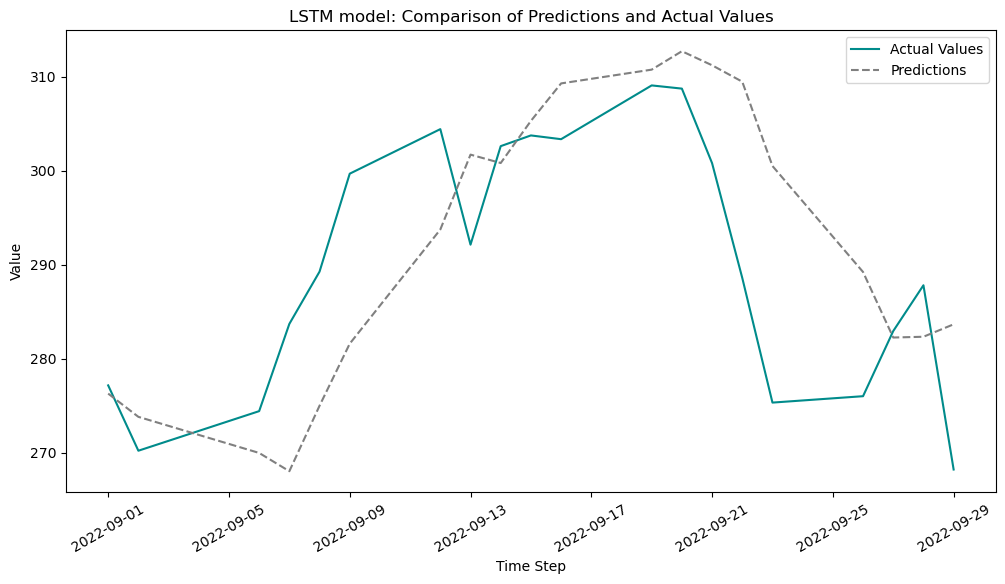

In [278]:
import matplotlib.dates as mdates

# Convert predictions and test_targets to a proper format for plotting
test_targets = y_scaler.inverse_transform(y_test).flatten()
predictions_ = y_scaler.inverse_transform(predictions).flatten()  # Flatten to make it easier to plot

plt.figure(figsize=(12, 6))
plt.plot(dates, test_targets, label='Actual Values', color='#008B8B')
plt.plot(dates, predictions_, label='Predictions', color='grey', linestyle='--') #marker='x'
plt.title('LSTM model: Comparison of Predictions and Actual Values')
plt.xlabel('Time Step')
plt.xticks(rotation = 30)

plt.ylabel('Value')
plt.legend()
#plt.grid(True)
plt.show()